In [14]:
import sys

import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import proplot as plot

plt.rcParams['grid.alpha'] = 0.04

sys.path.append('/Users/46h/Research/')
from accphys.tools import utils
from accphys.tools import beam_analysis as ba
from accphys.emittance_measurement_4D.data_analysis import reconstruct

sys.path.append('/Users/46h/Research/code/openxal-scripts/emittance_measurement_4D')
from lib.analysis_noxal import Measurement

In [4]:
moments_dicts = []
transfer_mats_dicts = []

turns_list = [126, 226, 326, 426, 526, 626, 726, 826, 926, 1026]
for turns in turns_list:
    folder = './{}/'.format(turns)
    for filename in utils.list_files(folder):
        if 'WireAnalysisFmt' in filename:
            print(filename)
            moments_dict = dict()
            measurement = Measurement(filename)
            for ws_id, moments in measurement.get_moments().items():
                moments_dict[ws_id] = moments
            moments_dicts.append(moments_dict)
        if 'transfer_mats' in filename:
            transfer_mats_dict = dict()
            file = open(filename)
            for line in file:
                tokens = line.split()
                ws_id = tokens[0]
                transfer_mat_elems = [float(token) for token in tokens[1:]]
                transfer_mat = np.reshape(transfer_mat_elems, (4, 4))
                transfer_mats_dict[ws_id] = transfer_mat
            file.close()
            transfer_mats_dicts.append(transfer_mats_dict)

./126/WireAnalysisFmt-2021.08.01_14.22.37.pta.txt
./226/WireAnalysisFmt-2021.08.01_14.17.06.pta.txt
./326/WireAnalysisFmt-2021.08.01_14.11.49.pta.txt
./426/WireAnalysisFmt-2021.08.01_14.06.47.pta.txt
./526/WireAnalysisFmt-2021.08.01_14.01.15.pta.txt
./626/WireAnalysisFmt-2021.08.01_13.56.05.pta.txt
./726/WireAnalysisFmt-2021.08.01_13.49.10.pta.txt
./826/WireAnalysisFmt-2021.08.01_13.44.05.pta.txt
./926/WireAnalysisFmt-2021.08.01_13.38.01.pta.txt
./1026/WireAnalysisFmt-2021.08.01_10.25.27.pta.txt


In [5]:
class BeamStats:
    """Container for beam statistics calculated from the covariance matrix."""
    def __init__(self, Sigma):
        self.Sigma = Sigma
        self.eps_x, self.eps_y = ba.apparent_emittances(Sigma)
        self.eps_1, self.eps_2 = ba.intrinsic_emittances(Sigma)
        self.alpha_x, self.alpha_y, self.beta_x, self.beta_y, _, _ = ba.get_twiss2D(Sigma)
        self.coupling_coeff = 1.0 - np.sqrt(self.eps_1 * self.eps_2 / (self.eps_x * self.eps_y))
    
    def show(self):
        print('eps_1, eps_2 = {} {} [mm mrad]'.format(self.eps_1, self.eps_2))
        print('eps_x, eps_y = {} {} [mm mrad]'.format(self.eps_x, self.eps_y))
        print('alpha_x, alpha_y = {} {} [rad]'.format(self.alpha_x, self.alpha_y))
        print('beta_x, beta_y = {} {} [m/rad]'.format(self.beta_x, self.beta_y))

In [6]:
stats_list = []

c = 0

for moments_dict, transfer_mats_dict in zip(moments_dicts, transfer_mats_dicts):

    moments_list, transfer_mats_list = [], []
    for ws_id in sorted(list(moments_dict)):
        moments_list.append(moments_dict[ws_id])
        transfer_mats_list.append(transfer_mats_dict[ws_id])

    Sigma = reconstruct(transfer_mats_list, moments_list)
    stats_list.append(BeamStats(Sigma))

/Users/46h/Research/accphys/tools/beam_analysis.py:75: RuntimeWarning: invalid value encountered in sqrt
  eps_2 = 0.5 * np.sqrt(-trSU2 - np.sqrt(trSU2**2 - 16 * detS))


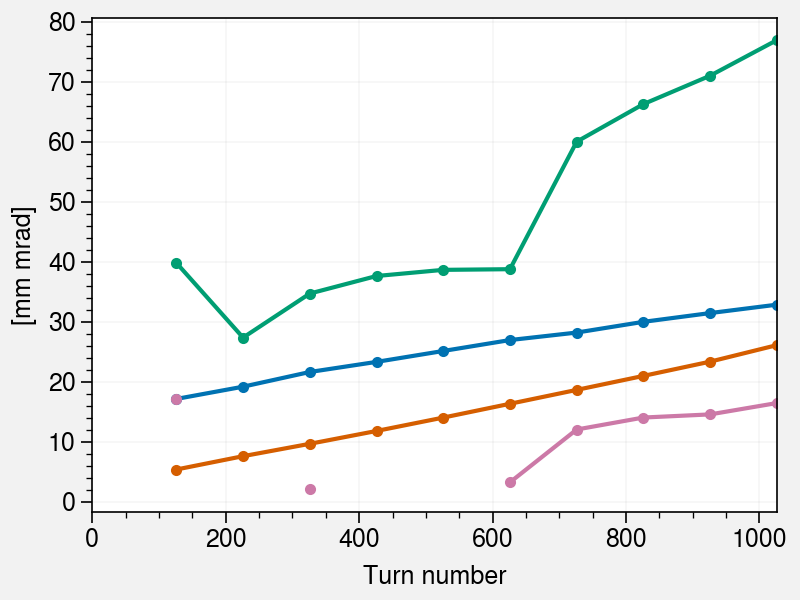

In [7]:
fig, ax = plot.subplots(figsize=(4, 3))
plt_kws = dict(marker='.',)
ax.plot(turns_list, [stats.eps_x for stats in stats_list], **plt_kws)
ax.plot(turns_list, [stats.eps_y for stats in stats_list], **plt_kws)
ax.plot(turns_list, [stats.eps_1 for stats in stats_list], **plt_kws)
ax.plot(turns_list, [stats.eps_2 for stats in stats_list], **plt_kws)
ax.format(xlim=(0, 1026), xlabel='Turn number', ylabel='[mm mrad]')
plt.savefig('/Users/46h/Desktop/test.png', dpi=300, facecolor='white')

## Add random noise 

In [12]:
for moments in moments_list:
    print(moments)

[224.45234691944643, 417.7831556660112, -15.632602212740522]
[512.7761621222598, 180.37716841453766, -21.369510437992275]
[460.19758811182504, 186.74741370990523, -1.0063083855666974]
[235.9694942052993, 426.3828324045316, -16.71778479548081]


In [13]:
for M in transfer_mats_list:
    print(M)

[[ -1.81271306   4.66457079   0.           0.        ]
 [  0.23635191  -1.15985275   0.           0.        ]
 [  0.           0.          -1.35509229 -11.05140109]
 [  0.           0.          -0.09889787  -1.54451475]]
[[-1.94687972  1.66551875  0.          0.        ]
 [-0.08621879 -0.43988387  0.          0.        ]
 [ 0.          0.         -0.65649845 -8.60299017]
 [ 0.          0.          0.18757844  0.93486198]]
[[ 1.13480151 -8.27739689  0.          0.        ]
 [ 0.28283083 -1.18179524  0.          0.        ]
 [ 0.          0.          0.55371487 -3.15701068]
 [ 0.          0.          0.05610743  1.48608658]]
[[ 1.43387292e+00 -6.27490487e+00  0.00000000e+00  0.00000000e+00]
 [-2.23772077e-04  6.98391146e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.45690909e+00  3.82953434e+00]
 [ 0.00000000e+00  0.00000000e+00  1.81143693e-01  1.16252689e+00]]


In [125]:
# Form A and b.
Axx, bxx = [], []
Ayy, byy = [], []
Axy, bxy = [], []
for M, (sig_xx, sig_yy, sig_xy) in zip(transfer_mats_list, moments_list):
    Axx.append([M[0][0]**2, M[0][1]**2, 2*M[0][0]*M[0][1]])
    Ayy.append([M[2][2]**2, M[2][3]**2, 2*M[2][2]*M[2][3]])
    Axy.append([M[0][0]*M[2][2],  M[0][1]*M[2][2],  M[0][0]*M[2][3],  M[0][1]*M[2][3]])
    bxx.append(sig_xx)
    byy.append(sig_yy)
    bxy.append(sig_xy)
    
# Try adding the same last equation, but with a tiny bit of noise.
last_row = np.array(Axy[-1])
frac_noise = 0.5
new_row = last_row * np.random.uniform(1 - frac_noise, 1 + frac_noise, size=last_row.shape)
# new_row = last_row * 1.0
print('Last row of Axy:', last_row)
print('Row to be added:', new_row)
Axy.append(new_row)
bxy.append(bxy[-1])

# Solve the problem Ax = b.
lsq_kws = dict(verbose=1)
result_xx = opt.lsq_linear(Axx, bxx, **lsq_kws)
result_yy = opt.lsq_linear(Ayy, byy, **lsq_kws) 
result_xy = opt.lsq_linear(Axy, bxy, **lsq_kws) 
sig_11, sig_22, sig_12 = result_xx.x
sig_33, sig_44, sig_34 = result_yy.x
sig_13, sig_23, sig_14, sig_24 = result_xy.x
Sigma = np.array([[sig_11, sig_12, sig_13, sig_14],
                  [sig_12, sig_22, sig_23, sig_24], 
                  [sig_13, sig_23, sig_33, sig_34],
                  [sig_14, sig_24, sig_34, sig_44]])
print()
print('Sigma =')
print(Sigma)
print('Corr =')
print(utils.cov2corr(Sigma))
stats = BeamStats(Sigma)
stats.show()

Last row of Axy: [  2.08902248  -9.14196593   5.49106557 -24.02996368]
Row to be added: [  1.94137713  -8.89515571   3.40236073 -20.47585727]
The unconstrained solution is optimal.
Final cost 3.7751e+02, first-order optimality 5.71e-11
The unconstrained solution is optimal.
Final cost 5.6325e+01, first-order optimality 3.39e-11
The unconstrained solution is optimal.
Final cost 1.1224e+01, first-order optimality 1.86e-11

Sigma =
[[ 1.97132266e+02  4.33795360e+01 -2.38665467e+02  1.39573743e+01]
 [ 4.33795360e+01  1.50053811e+01 -4.42234426e+01 -1.87512517e-01]
 [-2.38665467e+02 -4.42234426e+01  2.70539964e+02 -1.78106685e+01]
 [ 1.39573743e+01 -1.87512517e-01 -1.78106685e+01  3.68318385e+00]]
Corr =
[[ 1.          0.7975952  -1.0334632   0.51798021]
 [ 0.7975952   1.         -0.69408605 -0.0252229 ]
 [-1.0334632  -0.69408605  1.         -0.56422563]
 [ 0.51798021 -0.0252229  -0.56422563  1.        ]]
eps_1, eps_2 = 55.616970938290486 nan [mm mrad]
eps_x, eps_y = 32.80641146358513 26.06